In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os




### Read the dataset and show an example image

In [6]:
image_paths = sorted(glob.glob("UTKFace/*.jpg.chip.jpg"))

images = []
ages = []
genders = []
races = []

for path in image_paths:
    filename = path[8:].split("_")
    if len(filename)==4:
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))
print(len(images))
dataset_dict = {
    'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'
    },
    'gender_id': { 0: 'Male', 1: 'Female'
    }
}
idx = np.random.randint(low = 0, high = len(images))

plt.imshow(images[idx])
plt.show()

print("Age: "+str(ages[idx]))
print("Gender: "+str(dataset_dict['gender_id'][genders[idx]]))
print("Race: "+str(dataset_dict['race_id'][races[idx]]))



0


ValueError: high <= 0

### Age feature is on a different scale with gender and race. It makes sense to normalize it.

In [6]:

min_age_value, max_age_value = min(ages), max(ages)
log_age_values = np.log10(ages)
max_age_log_value = log_age_values.max()
print('MAX AGE VALUE', max_age_value)
print('MIN AGE VALUE', min_age_value)
print('MAX AGE LOG VALUE', max_age_log_value)

def get_normalized_age_value(original_age_value):
    return (original_age_value - min_age_value)/(max_age_value - min_age_value)

def get_log_age_value(original_age_value):
    return np.log10(original_age_value)/max_age_log_value

def get_original_age_from_log_value(log_age_value):
    return np.exp(log_age_value) * max_age_log_value

def get_original_age_value(normalized_age_value):
    return normalized_age_value * (max_age_value - min_age_value) + min_age_value

MAX AGE VALUE 116
MIN AGE VALUE 1
MAX AGE LOG VALUE 2.0644579892269186


### Exploratory data analysis
- the race part is not balanced. This can potentially cause problems: the model will mostly predict the white class. What can be done against it? 

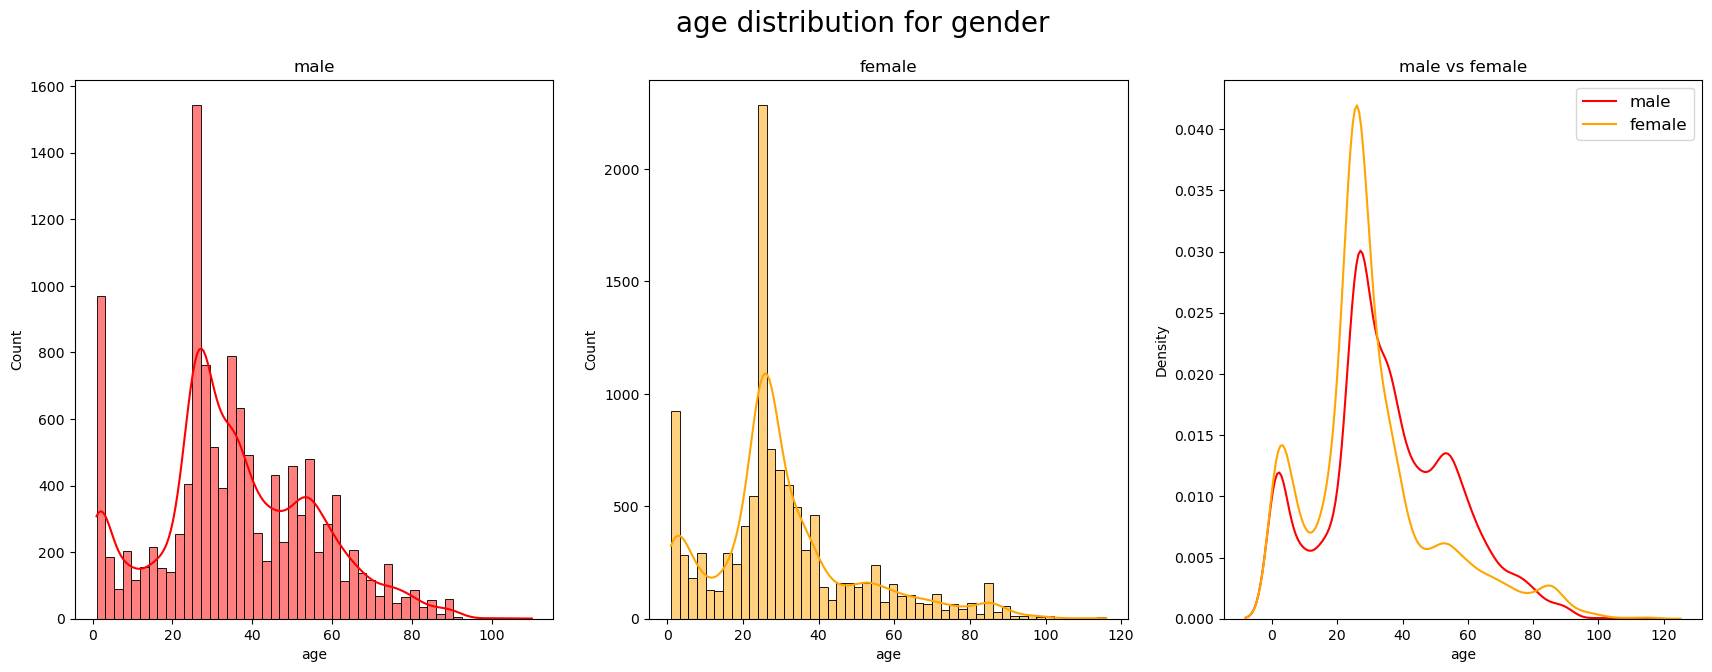

In [7]:
!pip install seaborn
import seaborn as sns
import pandas as pd

d = {'age': ages, 'gender': genders, 'race': races}
df = pd.DataFrame(data=d)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('age distribution for gender', fontsize=20)

df_age_male = df.groupby('gender').get_group(0)
df_age_female = df.groupby('gender').get_group(1)
sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
ax1.title.set_text("male")
ax2.title.set_text("female")


sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.title.set_text("male vs female")

plt.show()

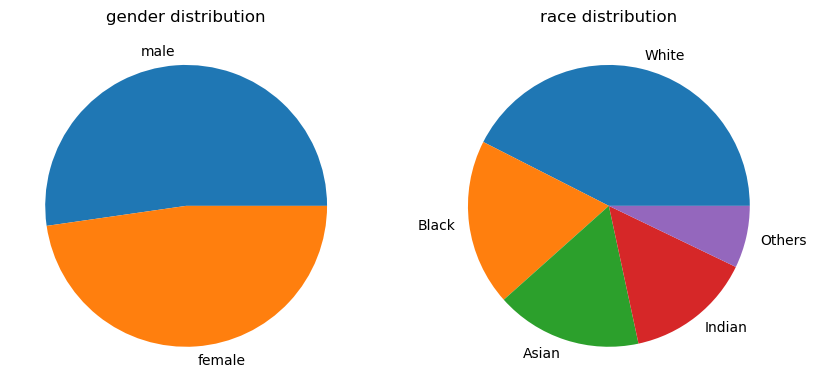

In [8]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
df.gender.value_counts().plot(kind='pie', labels=["male", "female"], pctdistance=0.5, ax = ax1)
ax1.yaxis.set_visible(False)
ax1.title.set_text('gender distribution')

df.race.value_counts().plot(kind='pie', labels=["White", "Black", "Asian", "Indian", "Others"], pctdistance=0.5, ax = ax2)
ax2.yaxis.set_visible(False)
ax2.title.set_text('race distribution')

plt.show()

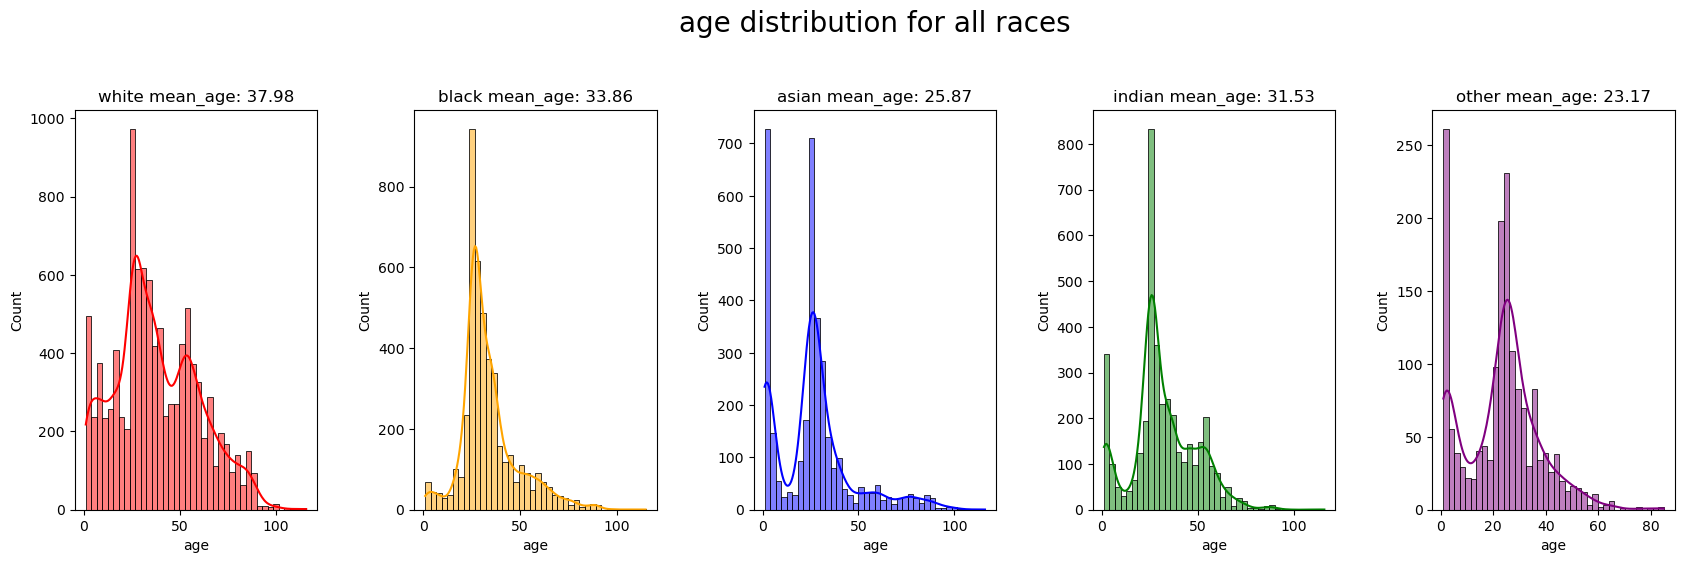

In [9]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('age distribution for all races', fontsize=20, y=1.1)
fig.tight_layout()

df_race_white = df.groupby('race').get_group(0)
sns.histplot(data=df_race_white, x="age", kde=True, color="red", ax=ax1, bins=40)
ax1.title.set_text("white mean_age: "+"%.2f" % df_race_white.mean()["age"])

df_race_black = df.groupby('race').get_group(1)
sns.histplot(data=df_race_black, x="age", kde=True, color="orange", ax=ax2, bins=40)
ax2.title.set_text("black mean_age: "+"%.2f" % df_race_black.mean()["age"])

df_race_asian = df.groupby('race').get_group(2)
sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", ax=ax3, bins=40)
ax3.title.set_text("asian")
ax3.title.set_text("asian mean_age: "+"%.2f" % df_race_asian.mean()["age"])

df_race_indian = df.groupby('race').get_group(3)
sns.histplot(data=df_race_indian, x="age", kde=True, color="green", ax=ax4, bins=40)
ax4.title.set_text("indian mean_age: "+"%.2f" % df_race_indian.mean()["age"])

df_race_other = df.groupby('race').get_group(4)
sns.histplot(data=df_race_other, x="age", kde=True, color="purple", ax=ax5, bins=40)
ax5.title.set_text("other mean_age: "+"%.2f" % df_race_other.mean()["age"])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

### Define the dataset. 

### Task 1: Redefine the dataset such that one could introduce different augmentations to the train set
- Hint: we discussed the possibilities in Lecture 2

In [10]:
class UTKFace(Dataset):
    def __init__(self, image_paths):
        # Mean and Std for ImageNet
        mean=[0.485, 0.456, 0.406] # ImageNet
        std=[0.229, 0.224, 0.225] # ImageNet

        # Define the Transforms
        self.transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean, std)])

        # Set Inputs and Labels
        self.image_paths = image_paths
        self.images = []
        self.ages = []
        self.genders = []
        self.races = []

        for path in image_paths:
            filename = path[8:].split("_")
            if len(filename)==4:
                self.images.append(path)
                self.ages.append(int(filename[0]))
                self.genders.append(int(filename[1]))
                self.races.append(int(filename[2]))
    
    def __len__(self):
         return len(self.images)

    def __getitem__(self, index):
        # Load an Image
        img = Image.open(self.images[index]).convert('RGB')
        # Transform it
        img = self.transform(img)

        # Get the Labels
        age = self.ages[index]
        gender = self.genders[index]
        race = self.races[index]
        
        # Return the sample of the dataset
        sample = {'image':img, 'age': age, 'gender': gender, 'race':race}
        return sample

In [11]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# define the train and val splits
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.3

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_train = round(TRAIN_SPLIT*len(image_paths))
num_val = round(VAL_SPLIT*len(image_paths))

print('No of train samples', num_train)
print('No of validation Samples', num_val)

(train_dataset, valid_dataset) = random_split(image_paths,[num_train, num_val],generator=torch.Generator().manual_seed(42))

No of train samples 16595
No of validation Samples 7112


In [12]:
BATCH_SIZE = 64

train_dataloader = DataLoader(UTKFace(train_dataset), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(UTKFace(valid_dataset), shuffle=False, batch_size=BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

In [13]:
def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
	# convert to Numpy
    npimg = img.numpy()
	# Transpose to get the correct color
    npimg=np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


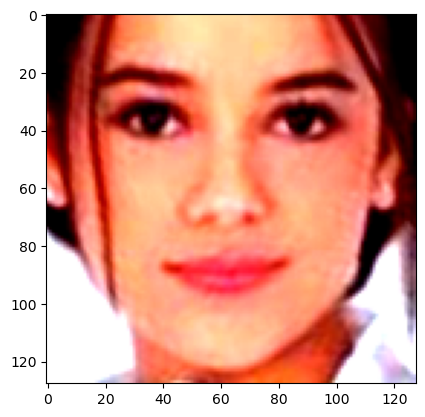

18
0.14782608695652175
Female
White


In [14]:
sample = next(iter(train_dataloader))

imshow(sample['image'][0])
plt.show()
print(sample["age"][0].item())
print(get_normalized_age_value(sample["age"][0].item()))


print(dataset_dict['gender_id'][sample["gender"][0].item()])
print(dataset_dict['race_id'][sample["race"][0].item()])

### Define the network
### Task 2: Experiment with different backbones and head setups

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, resnet101, resnet18, resnet34
from collections import OrderedDict

class MultiTaskNet(nn.Module):
    def __init__(self, net):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc_age = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc_gender = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc_race = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 5))]))
        
    def forward(self, x):
        age_head = self.net.fc_age(self.net(x))
        gender_head = self.net.fc_gender(self.net(x))
        race_head = self.net.fc_race(self.net(x))
        return age_head, gender_head, race_head

In [16]:
net = resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
model = MultiTaskNet(net)
model.to(device=device)

race_loss = nn.CrossEntropyLoss() # Includes Softmax
gender_loss = nn.BCEWithLogitsLoss() # Includes Sigmoid
age_loss = nn.L1Loss()

lr = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.09)

In [17]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = 100

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_race_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_race_loss": list(),
          "validation_age_loss": list(),
          }

In [19]:
for epoch in range(n_epochs):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_race_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_race_loss = 0
    validation_age_loss = 0

    for i, data in enumerate(train_dataloader):
        inputs = data["image"].to(device=device)
        age_label = get_normalized_age_value(data["age"]).to(device=device)
        gender_label = data["gender"].to(device=device)
        race_label = data["race"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, race_output = model(inputs)
        
        loss_1 = age_loss(age_output, age_label.unsqueeze(1).float())
        loss_2 = gender_loss(gender_output, gender_label.unsqueeze(1).float())
        loss_3 = race_loss(race_output, race_label)
        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss
        
        training_race_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_age_loss += loss_3.item()
    print('EPOCH ', epoch+1)
    

    with torch.no_grad():
        model.eval()

        for i, data in enumerate(val_dataloader):
            inputs = data["image"].to(device=device)
            age_label = get_normalized_age_value(data["age"]).to(device=device)
            gender_label = data["gender"].to(device=device)
            race_label =  data["race"].to(device=device)
            age_output, gender_output, race_output = model(inputs)
        
            loss_1 = race_loss(race_output, race_label)
            loss_2 = gender_loss(gender_output, gender_label.unsqueeze(1).float())
            loss_3 = age_loss(age_output, age_label.unsqueeze(1).float())

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss

            validation_race_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_age_loss += loss_3.item()
        

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_dataloader.dataset)
    avgTrainRaceLoss = training_race_loss/len(train_dataloader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_dataloader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_dataloader.dataset)
    avgValRaceLoss = validation_race_loss/len(val_dataloader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_race_loss"].append(avgTrainRaceLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_race_loss"].append(avgValRaceLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)


EPOCH  1
Average Losses — Training: 2.4149630069732666 | Validation 2.3587629795074463

EPOCH  2
Average Losses — Training: 2.3057057857513428 | Validation 2.2991068363189697

EPOCH  3
Average Losses — Training: 2.2524735927581787 | Validation 2.2515316009521484

EPOCH  4
Average Losses — Training: 2.2133865356445312 | Validation 2.217090606689453

EPOCH  5
Average Losses — Training: 2.177729606628418 | Validation 2.183384895324707

EPOCH  6
Average Losses — Training: 2.1415536403656006 | Validation 2.1495513916015625

EPOCH  7
Average Losses — Training: 2.110018491744995 | Validation 2.117568254470825

EPOCH  8
Average Losses — Training: 2.077890634536743 | Validation 2.085479974746704

EPOCH  9
Average Losses — Training: 2.043333053588867 | Validation 2.057222604751587

EPOCH  10
Average Losses — Training: 2.0140280723571777 | Validation 2.0278189182281494

EPOCH  11
Average Losses — Training: 1.9809216260910034 | Validation 1.9944194555282593

EPOCH  12
Average Losses — Training: 1.

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

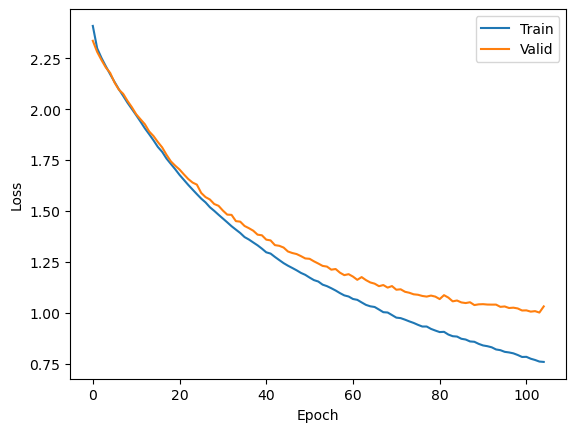

In [ ]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

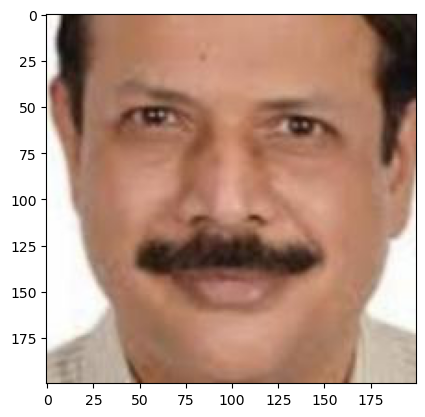

(200, 200, 3)
Age: 43 | Predicted: 38
Gender: Male | Predicted: male
Race: Indian | Predicted: indian




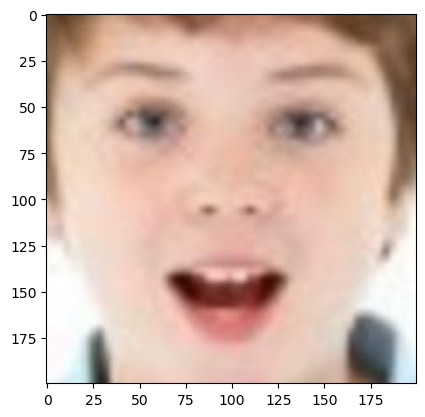

(200, 200, 3)
Age: 11 | Predicted: 22
Gender: Male | Predicted: female
Race: White | Predicted: white




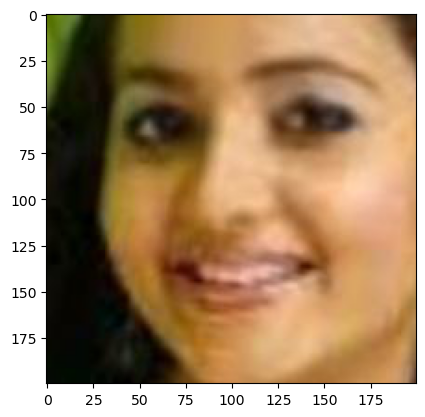

(200, 200, 3)
Age: 23 | Predicted: 38
Gender: Female | Predicted: female
Race: Indian | Predicted: indian




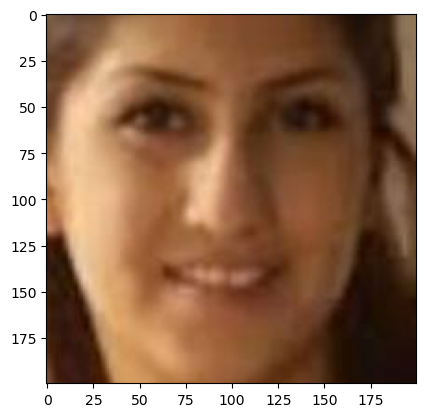

(200, 200, 3)
Age: 22 | Predicted: 24
Gender: Female | Predicted: female
Race: Indian | Predicted: white




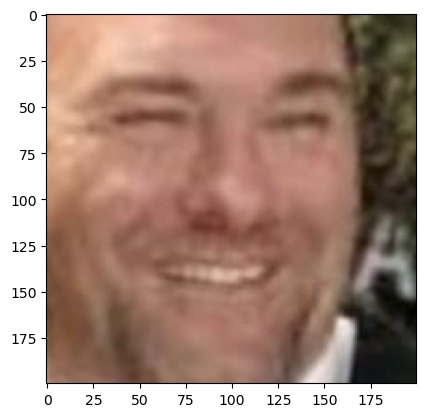

(200, 200, 3)
Age: 52 | Predicted: 52
Gender: Male | Predicted: male
Race: White | Predicted: white




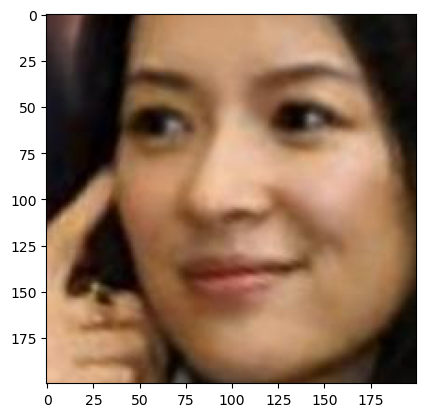

(200, 200, 3)
Age: 26 | Predicted: 20
Gender: Female | Predicted: female
Race: Asian | Predicted: asian




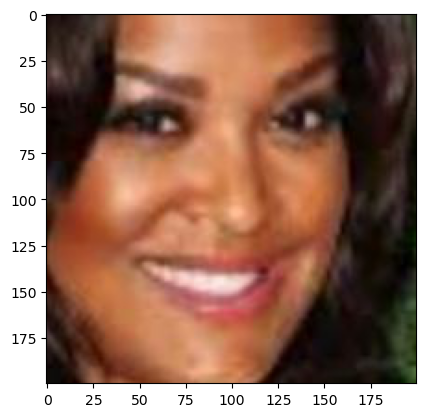

(200, 200, 3)
Age: 27 | Predicted: 30
Gender: Female | Predicted: female
Race: Black | Predicted: black




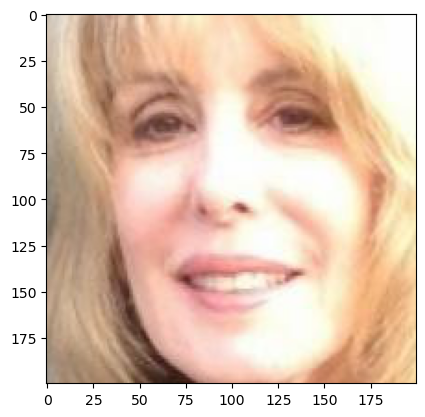

(200, 200, 3)
Age: 60 | Predicted: 32
Gender: Female | Predicted: female
Race: White | Predicted: white




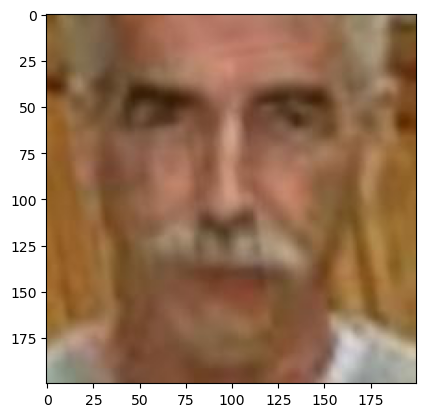

(200, 200, 3)
Age: 54 | Predicted: 44
Gender: Male | Predicted: male
Race: White | Predicted: white




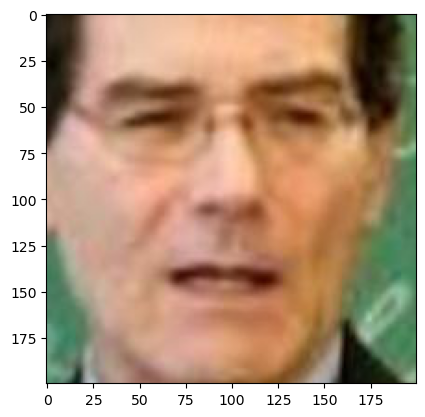

(200, 200, 3)
Age: 50 | Predicted: 47
Gender: Male | Predicted: male
Race: White | Predicted: white




In [ ]:
indexes = valid_dataset.indices
test_indices = indexes[0:10]

mean=[0.485, 0.456, 0.406] # ImageNet
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean, std)])

sigmoid = nn.Sigmoid()

for idx in test_indices:
    plt.figure()
    plt.imshow(images[idx])
    plt.show()
    
    print (images[idx].shape)

    img = transform(Image.fromarray(images[idx]))
    
    img = img.unsqueeze(0)

    model.eval()
    age, gender, race = model(img.to(device=device))

    predicted_age = int(get_original_age_value(age.squeeze(0).item()))

    print("Age:", str(ages[idx]), "| Predicted:", str(int(predicted_age)))

    out_gender = int(torch.round(sigmoid(gender)).item())
    #print (out_gender)
    
    gender_classes = ["male", "female"]
    print("Gender:", str(dataset_dict['gender_id'][genders[idx]]), "| Predicted:", str(gender_classes[out_gender]))

    out_race = torch.argmax(F.softmax(race, dim=1)).item()
    race_classes = ["white", "black", "asian", "indian", "other"]
    print("Race:", str(dataset_dict['race_id'][races[idx]]), "| Predicted:", str(race_classes[out_race]))
    print('\n')